In [1]:
# Import libraries

# Basic
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.feature_selection import RFECV, SelectKBest
from sklearn.ensemble import GradientBoostingRegressor


# My own cleaning libraryb
import cleaning_tools as ct
import tools

# For reloading my tools, while working on them
from importlib import reload

import warnings
warnings.filterwarnings('ignore')

seed = 42

In [2]:
for c in str_cols:
    if data[c].isnull().sum() != 0:
        print(c, data[c].isnull().sum())

NameError: name 'str_cols' is not defined

In [83]:
# Load Training df
data = tools.load_data('../data/train.csv')

def clean(df):
    
    # Map to number
    df = ct.map_to_number(df)
    
    # Transform columns
    df['MS_SubClass'] = df.MS_SubClass.apply(lambda x: str(x))
    df['Total_SF']      = df['Total_Bsmt_SF'] + df['1st_Flr_SF'] + df['2nd_Flr_SF']
    df['porch_area']    = df['Open_Porch_SF'] + df['Enclosed_Porch'] + df['3Ssn_Porch'] + df['Screen_Porch']
    df['Overall_Qual2'] = df['Overall_Qual']**2
    
    df.drop(['Open_Porch_SF', 'Enclosed_Porch', '3Ssn_Porch', 'Screen_Porch'], axis=1, inplace=True)
    df.drop(['Total_Bsmt_SF', '1st_Flr_SF', '2nd_Flr_SF'], axis=1, inplace=True)
    df.drop('Garage_Cars', axis=1, inplace=True)
    df.drop('Pool_Area',   axis=1, inplace=True)
    #df.drop('MS_SubClass', axis=1, inplace=True)
    df.drop('Kitchen_AbvGr', axis=1, inplace=True)
    df.drop(['Id', 'PID'], axis=1, inplace=True)
    df.drop(['Alley', 'Misc_Feature', 'Fence'], axis=1, inplace=True)   

    df = pd.get_dummies(df, columns=['MS_SubClass'])
    df = pd.get_dummies(df, columns=['Neighborhood'])
    df = pd.get_dummies(df, columns=['Bldg_Type'])
    df = pd.get_dummies(df, columns=['MS_Zoning'])
    
    
    return df

data = clean(data)


# Outliers :
data = data[data['SalePrice']    < 500000]
data = data[data['Total_SF']     < 10000]
data = data[data['Lot_Frontage'] < 250]
data = data[data['Lot_Area']     < 50000]

# Split X/y
y = data[['SalePrice']].copy()
X = data.drop('SalePrice', axis=1)

# num types
num_types = [np.int64, np.uint8, np.float64]

# Add
num_cols = [c for c in X.columns if X[c].dtype in num_types]
str_cols = [c for c in X.columns if X[c].dtype not in num_types]
X = X[num_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

imputer = Imputer(strategy='median').fit(X_train)
X_train = imputer.transform(X_train)
X_test  = imputer.transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [67]:
X_train.shape

(1182, 96)

best train k:  55
best test k:  55


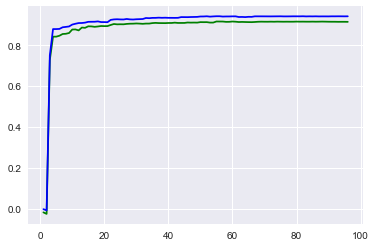

In [69]:
# R = GradientBoostingRegressor(n_estimators = best['n_estimators'],
#                               max_depth=best['max_depth'],
#                               alpha=best['alpha'],
#                               learning_rate=best['learning_rate'],
#                               )
R = GradientBoostingRegressor()
scores1 = []
scores2 = []
ks = [i for i in range(1, X_train.shape[1]+1)]
for k in ks:
    selector = SelectKBest(k=k)
    selector.fit(X_train, y_train)
    
    x1 = selector.transform(X_train)
    x2 = selector.transform(X_test)
    
    cvs = cross_val_score(R, x1, y_train, cv=3)
    
    R.fit(x1, y_train)
    s2 = R.score(x2, y_test)
    
    scores1.append(cvs.mean())
    scores2.append(s2)

best_train = ks[scores1.index(max(scores1))]
best_test  = ks[scores2.index(max(scores2))]

f, ax = plt.subplots()
ax.plot(ks, scores1, 'green')
ax.plot(ks, scores2, 'blue')
print('best train k: ',  best_train)
print('best test k: ',  best_test)

In [70]:
selector = SelectKBest(k=best_test)
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

In [74]:
params = {'n_estimators': [50, 100, 150],
          'learning_rate': [0.01, 0.4, 0.45],
          'alpha' : [0.001, 0.01, 0.1],
          'max_depth' : [2]
         }

estimator = GradientBoostingRegressor()
GSV = GridSearchCV(estimator, param_grid=params, n_jobs=-1)
GSV.fit(X_train, y_train)
best = GSV.best_params_
print(best)

{'alpha': 0.001, 'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 100}


In [150]:
GSV.best_score_

0.88063718070395314

In [75]:
R = GradientBoostingRegressor(n_estimators = best['n_estimators'],
                              max_depth=best['max_depth'],
                              alpha=best['alpha'],
                              learning_rate=best['learning_rate'],
                             )

print(cross_val_score(R, X_train, y_train, cv=3).mean())

R.fit(X_train, y_train)
print(R.score(X_test, y_test))

0.901765685681
0.931579483492


In [78]:
data_test = tools.load_data('../data/test.csv')
ids       = data_test[['Id']].copy()

data_test = clean(data_test)
data_test['Neighborhood_GrnHill'] = 0
data_test['Neighborhood_Landmrk'] = 0
data_test['MS_Zoning_A (agr)']   = 0
data_test['MS_SubClass_150']   = 0


X_final = data_test[num_cols]
X_final = imputer.transform(X_final)
X_final = scaler.transform(X_final)
X_final = selector.transform(X_final)
y_final = pd.DataFrame(R.predict(X_final), columns=['SalePrice'])

final_df = pd.concat([ids, y_final], axis=1)
final_df.to_csv('sub6_gbr_withDummies.csv', index=False)

In [259]:
y_final.mean()

SalePrice    178807.019155
dtype: float64